<a href="https://colab.research.google.com/github/gyuwonchoi/PytorchTutorial/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# img: load in NumPy -> torch.*Tensor
# img-lib: Pillow, OpenCV
# img-module: torchvision
    ## data loader, torchvision.datasets, torch.utils.data.DataLoader

1. torchvision으로 set 불러오고, 정규화
2. CNN의 정의
3. 손실 함수의 정의
4. 학습용 데이터로 학습
5. 테스트 데이터로 테스트

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# output of torchvision dataset: [0,1] ranged PILImage -> need to normalize [-1, 1]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),  # R G B mean
                          (0.5, 0.5, 0.5))] # R G B std
)

batch_size=4

trainset= torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader= torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset= torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader= torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


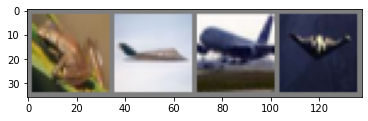

frog  plane plane plane


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize :  mean 0.5, std 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [3]:
from os import XATTR_REPLACE
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(3,6,5) # input channel, output channel, kernel size
    self.pool=nn.MaxPool2d(2,2)
    self.conv2= nn.Conv2d(6,16,5)
    self.fc1=nn.Linear(16*5*5, 120)
    self.fc2=nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
  
  def forward(self,x):
    x= self.pool(F.relu(self.conv1(x)))
    x= self.pool(F.relu(self.conv2(x)))
    x= torch.flatten(x,1)
    x= F.relu(self.fc1(x))
    x= F.relu(self.fc2(x))
    x= self.fc3(x)
    return x

net=Net()
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [4]:
import torch.optim as optim

criterion=nn.CrossEntropyLoss()  # loss func
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # how to optimizer from loss

In [5]:
for epoch in range(2):
  running_loss =0.0
  for i, data in enumerate(trainloader,0):
    # data set은 [input, labels]의 딕셔너리
    inputs, labels = data

    # gradient 를 일단 초기화, 매번 돌때마다 새로 업데이트 해야지
    optimizer.zero_grad()

    outputs= net(inputs) # forward propa

    loss=criterion(outputs, labels)
    loss.backward() # back propa
    
    optimizer.step() # gradient update

    running_loss += loss.item() # loss 2000회씩 누적: 매 회당 확률로 0-1 사이니까 2000으로 나눠줌
    if i%2000== 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0  # 매 epoch 마다 loss 다르므로 

print("Finished!")
 

[1,  2000] loss: 2.227
[1,  4000] loss: 1.907
[1,  6000] loss: 1.707
[1,  8000] loss: 1.589
[1, 10000] loss: 1.483
[1, 12000] loss: 1.478
[2,  2000] loss: 1.386
[2,  4000] loss: 1.383
[2,  6000] loss: 1.347
[2,  8000] loss: 1.310
[2, 10000] loss: 1.300
[2, 12000] loss: 1.267
Finished!


In [6]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(),PATH)

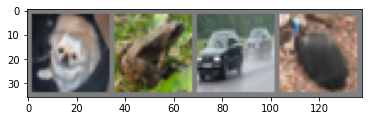

GroundTruth:  dog   frog  car   bird 


In [7]:
dataiter=iter(testloader)
imgaes, labels = dataiter.next()

imshow(torchvision.utils.make_grid(imgaes))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
net=Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [9]:
outputs= net(images)

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  plane plane plane


https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

###5.시험용 데이터로 신경망 검사하기


In [15]:
correct=0
total=0

# for the tests, we don't need to update the gradient 
with torch.no_grad():
  for data in testloader:
    images, labels = data

    #infer
    outputs=net(images)

    _, predicted=torch.max(outputs.data, 1) # 각 배치에서 10classese에 대한 스코어 10개 중 가장 큰 값에 대하여
                                            # (value, indx) 튜플로 리턴, 즉 여기서는 몇번째 클래스인지 봄 
    # print(outputs.data.shape()

    # 이미지 중에 맞힌 개수로 accuracy 계산
    # print(predicted)
    
    print(labels)
    total+= labels.size(0) # num of imgs per batch
    correct+= (predicted==labels).sum().item()  # 확률 가장 높은 클래스 인덱스가 GT면 정확도 업 

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

tensor([0, 1, 3, 1])
tensor([1, 1, 7, 7])
tensor([9, 5, 0, 1])
tensor([6, 2, 9, 2])
tensor([8, 0, 3, 8])
tensor([9, 7, 9, 7])
tensor([7, 6, 4, 4])
tensor([0, 1, 5, 4])
tensor([1, 6, 1, 0])
tensor([6, 6, 1, 8])
tensor([7, 5, 1, 4])
tensor([0, 5, 4, 0])
tensor([6, 1, 3, 0])
tensor([6, 4, 1, 9])
tensor([7, 2, 4, 4])
tensor([8, 2, 8, 1])
tensor([6, 8, 5, 6])
tensor([4, 0, 0, 3])
tensor([1, 1, 6, 4])
tensor([5, 8, 8, 8])
tensor([8, 2, 0, 4])
tensor([1, 9, 1, 9])
tensor([0, 0, 4, 5])
tensor([9, 5, 7, 1])
tensor([7, 0, 1, 3])
tensor([2, 4, 7, 1])
tensor([7, 4, 3, 3])
tensor([3, 2, 3, 5])
tensor([0, 7, 4, 9])
tensor([2, 8, 3, 7])
tensor([9, 1, 0, 0])
tensor([4, 7, 8, 1])
tensor([9, 6, 2, 5])
tensor([6, 5, 6, 1])
tensor([2, 7, 3, 3])
tensor([6, 9, 4, 9])
tensor([0, 9, 5, 5])
tensor([2, 0, 4, 4])
tensor([1, 2, 3, 2])
tensor([1, 0, 2, 2])
tensor([0, 6, 2, 0])
tensor([0, 4, 9, 4])
tensor([5, 3, 2, 1])
tensor([3, 5, 4, 8])
tensor([9, 5, 8, 4])
tensor([1, 4, 0, 9])
tensor([0, 5, 8, 9])
tensor([6, 3,

KeyboardInterrupt: ignored

In [ ]:
corred_pred={classname:0 for classname in classes}
total_pred={classname:0 for classname in classes}

